In [5]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import scipy as sp
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import src.data_retriever as intrinio
import random
random.seed(42)
import src.pso as pso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [6]:
datefrom = dtm.datetime(2012, 1, 1)
dateto = dtm.datetime(2019, 1, 1)

In [7]:
#DOW 30
stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
# stock_names = ['AAPL']

In [8]:
stocks_filename = 'stocks.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=stocks.columns)

### Подготовка к обучению

In [9]:
train_datefrom = dtm.datetime(2017, 1, 1)
train_dateto = dtm.datetime(2018, 6, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2019, 1, 1)

In [10]:
data = stocks.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#to_normalize = ['volume_prev1', 'ebitda']
data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))
data['stock_name'] = LabelEncoder().fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

17753


In [13]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_regr = valid_data['close']
Y_valid_classify =valid_data['close'] > valid_data['open']

1605


In [18]:
ts = time.time()

model_regr = XGBRegressor(seed=42)

model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        eval_metric='mae',
        verbose=True, 
        early_stopping_rounds = 20)
    
time.time() - ts

[0]	validation_0-mae:102.902	validation_1-mae:140.783
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:92.6241	validation_1-mae:127.982
[2]	validation_0-mae:83.373	validation_1-mae:115.266
[3]	validation_0-mae:75.0457	validation_1-mae:104.862
[4]	validation_0-mae:67.5551	validation_1-mae:94.7894
[5]	validation_0-mae:60.8238	validation_1-mae:85.8189
[6]	validation_0-mae:54.7792	validation_1-mae:77.5312
[7]	validation_0-mae:49.3464	validation_1-mae:69.9059
[8]	validation_0-mae:44.4484	validation_1-mae:62.9788
[9]	validation_0-mae:40.0786	validation_1-mae:56.9012
[10]	validation_0-mae:36.1061	validation_1-mae:51.1243
[11]	validation_0-mae:32.5835	validation_1-mae:46.2238
[12]	validation_0-mae:29.3582	validation_1-mae:41.5918
[13]	validation_0-mae:26.5156	validation_1-mae:37.6882
[14]	validation_0-mae:23.942	validation_1-mae:34.1256
[15]	validation_0-mae:21.5763	

9.024860858917236

In [21]:
ts = time.time()

model_class = XGBClassifier(seed=42)

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='error',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-error:0.410916	validation_1-error:0.406854
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.405565	validation_1-error:0.418692
[2]	validation_0-error:0.38985	validation_1-error:0.403738
[3]	validation_0-error:0.386414	validation_1-error:0.4
[4]	validation_0-error:0.384667	validation_1-error:0.406854
[5]	validation_0-error:0.383034	validation_1-error:0.405607
[6]	validation_0-error:0.373233	validation_1-error:0.384424
[7]	validation_0-error:0.370642	validation_1-error:0.383801
[8]	validation_0-error:0.369459	validation_1-error:0.382555
[9]	validation_0-error:0.36484	validation_1-error:0.373209
[10]	validation_0-error:0.362361	validation_1-error:0.376947
[11]	validation_0-error:0.360333	validation_1-error:0.376324
[12]	validation_0-error:0.359827	validation_1-error:0.370717
[13]	validation_0-error:0.360164	validation_1-error:0.373209
[1

3.043858528137207

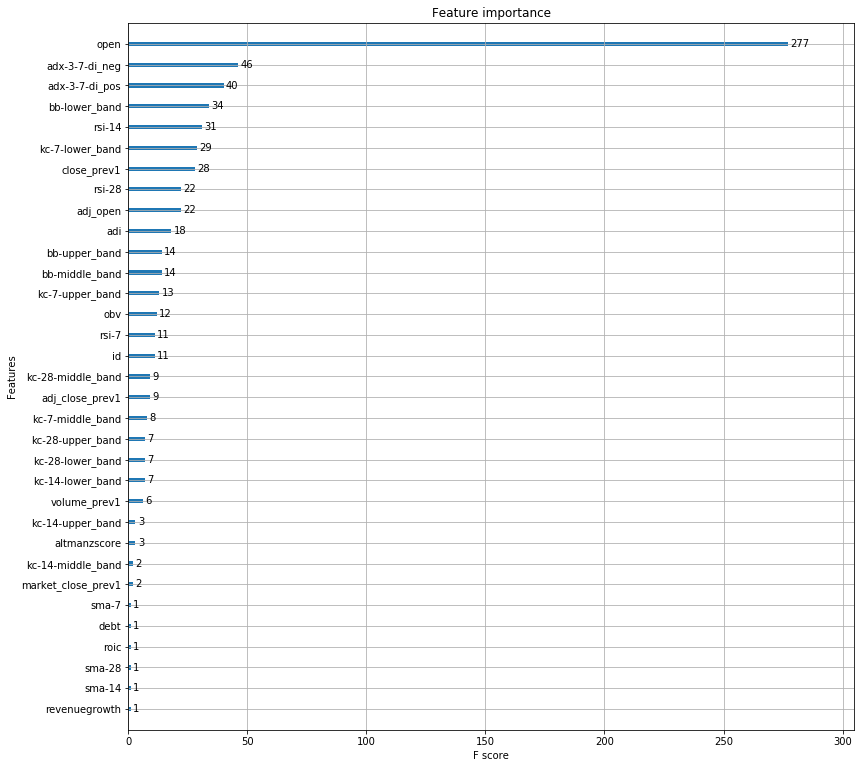

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_regr, ax=ax)

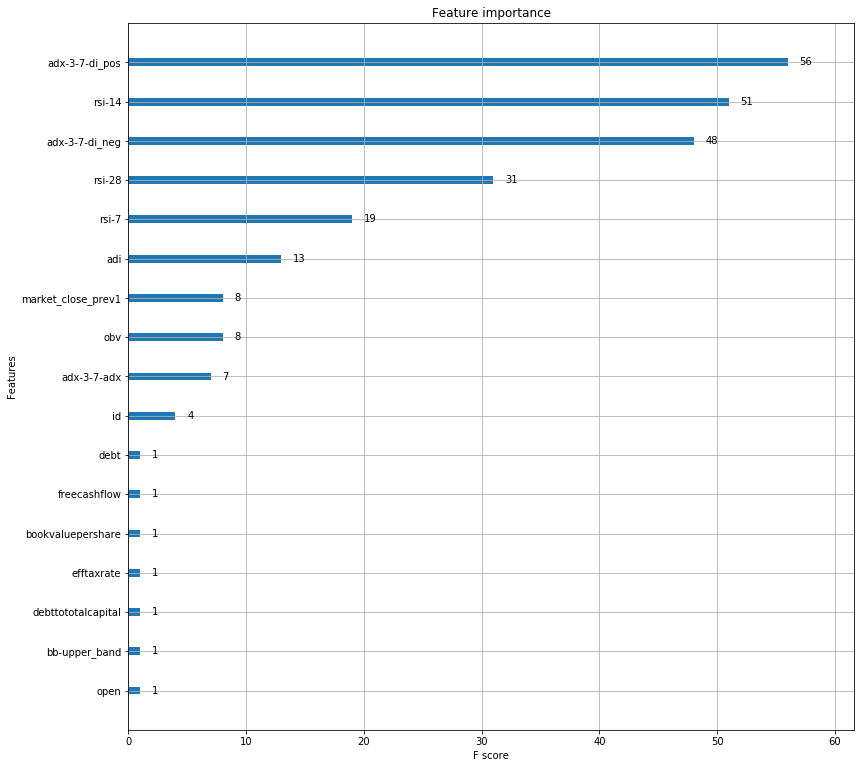

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_class, ax=ax)

In [0]:
def fitness_regr(params):
    params['seed'] = 42
    params['n_jobs'] = 4
    model_regr = XGBRegressor(**params)  

    model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)],   
        verbose=False,
        eval_metric='mae',
        early_stopping_rounds = 10)
    return model_regr.best_score

def fitness_class(params):
    params['seed'] = 42
    params['n_jobs'] = 4
    model_class = XGBClassifier(**params)  

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=False,
        eval_metric='error',
        early_stopping_rounds = 10)
    return model_class.best_score

patterns = [
    ("max_depth", int, 1, 50),
    ("n_estimators", int, 10, 10000),
    ("min_child_weight", int, 10, 5000),
    ("colsample_bytree", float, 0.0, 1.0),
    ("subsample", float, 0.1, 1.0),
    ("eta", float, 0.0, 1.0),
]

In [20]:
ts = time.time()
opt_class, fitness_class = pso.optimize(patterns, fitness_class)
time.time() - ts

n_estimators.dim_velocity = 0.0
*[1]particle.values={'max_depth': 41, 'n_estimators': 1834, 'min_child_weight': 214, 'colsample_bytree': 0.7415504997598329, 'subsample': 0.3204026684231286, 'eta': 0.1395379285251439}
n_estimators.dim_velocity = -2505.1051636621605
*[1]particle.values={'max_depth': 21, 'n_estimators': 6439, 'min_child_weight': 664, 'colsample_bytree': 0.5965191201678559, 'subsample': 0.1382903605856734, 'eta': 0.10826598189493027}
n_estimators.dim_velocity = -861.6709206635134
*[1]particle.values={'max_depth': 19, 'n_estimators': 7427, 'min_child_weight': 3409, 'colsample_bytree': 0.0877192797434631, 'subsample': 0.2823403028548622, 'eta': 0.39738454386798144}
n_estimators.dim_velocity = -2127.7796725191743
*[1]particle.values={'max_depth': 36, 'n_estimators': 4755, 'min_child_weight': 1631, 'colsample_bytree': 0.4953190475703636, 'subsample': 0.34721016825974976, 'eta': 0.5495302529925641}
n_estimators.dim_velocity = -361.70357174238495
*[1]particle.values={'max_depth'

322.50444078445435

In [21]:
opt_class, fitness_class

({'colsample_bytree': 0.5845984412067572,
  'eta': 0.1621373852417278,
  'max_depth': 35,
  'min_child_weight': 99,
  'n_estimators': 2252,
  'subsample': 0.3196129527799157},
 0.330218)

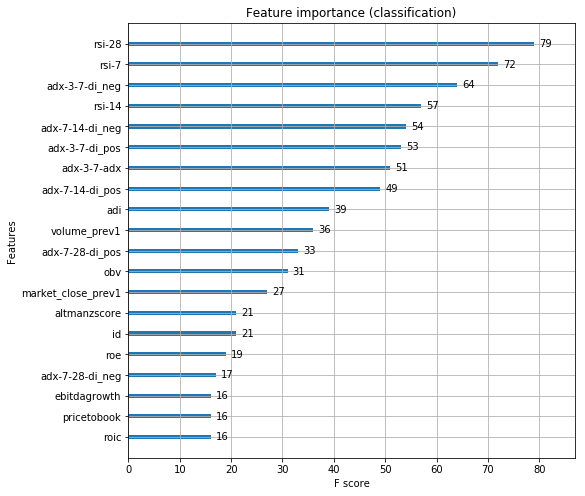

In [28]:
params_pso_class = {'colsample_bytree': 0.5845984412067572,
  'eta': 0.1621373852417278,
  'max_depth': 35,
  'min_child_weight': 99,
  'n_estimators': 2252,
  'subsample': 0.3196129527799157,
  'seed': 42}
model_pso_class_opt = XGBRegressor(**params_pso_class)
model_pso_class_opt.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=False,
        eval_metric='error',
        early_stopping_rounds = 10)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=model_pso_class_opt, ax=ax, max_num_features=20, title='Feature importance (classification)')

In [22]:
ts = time.time()
opt_regr, fitness_regr = pso.optimize(patterns, fitness_regr)
time.time() - ts

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


n_estimators.dim_velocity = 370.80498426103435
*[1]particle.values={'max_depth': 12, 'n_estimators': 4445, 'min_child_weight': 4508, 'colsample_bytree': 0.62496312878457, 'subsample': 0.7510371488846959, 'eta': 0.27337522182026225}
n_estimators.dim_velocity = 1545.0361209296711
*[1]particle.values={'max_depth': 40, 'n_estimators': 1994, 'min_child_weight': 1937, 'colsample_bytree': 0.2856832665861801, 'subsample': 0.6892262273730061, 'eta': 0.20912864563128636}
n_estimators.dim_velocity = 0.0
*[1]particle.values={'max_depth': 26, 'n_estimators': 4852, 'min_child_weight': 457, 'colsample_bytree': 0.7838015995764177, 'subsample': 0.8144002285540428, 'eta': 0.2393410764253714}
n_estimators.dim_velocity = 1110.6860298136876
*[1]particle.values={'max_depth': 25, 'n_estimators': 2967, 'min_child_weight': 1892, 'colsample_bytree': 0.5992723207239081, 'subsample': 0.7202431762157342, 'eta': 0.41516623071515996}
n_estimators.dim_velocity = -419.46357722616233
*[1]particle.values={'max_depth': 3

2092.300615787506

In [23]:
opt_regr, fitness_regr

({'colsample_bytree': 0.6160255388578953,
  'eta': 0.2695933770248609,
  'max_depth': 13,
  'min_child_weight': 229,
  'n_estimators': 4946,
  'subsample': 0.8236539165798413},
 1.61276)

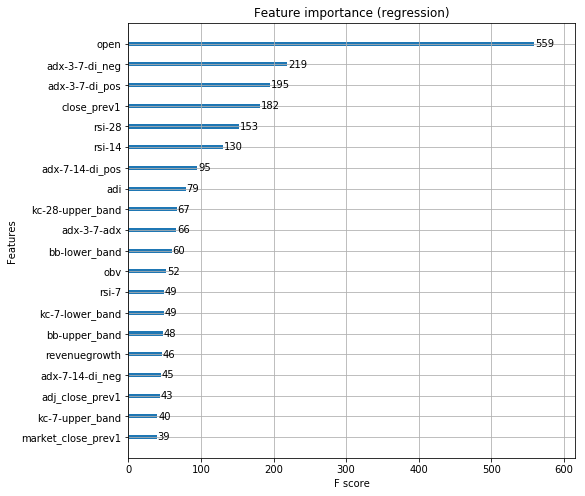

In [29]:
params_pso_regr = {'colsample_bytree': 0.6160255388578953,
  'eta': 0.2695933770248609,
  'max_depth': 13,
  'min_child_weight': 229,
  'n_estimators': 4946,
  'subsample': 0.8236539165798413,
  'seed': 42}
model_pso_regr_opt = XGBRegressor(**params_pso_regr)
model_pso_regr_opt.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)],   
        verbose=False,
        eval_metric='mae',
        early_stopping_rounds = 10)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=model_pso_regr_opt, ax=ax, max_num_features=20, title='Feature importance (regression)')

In [37]:
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
search_classif=RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, scoring="accuracy", n_jobs=4, verbose=10)
search_classif.fit(X_train, Y_train_classify)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 17.2min remaining:  1.9min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 19.2min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b366cba8>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b366ce80>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b36810b8>, 'subsample': <...t at 0x7f06b3681828>, 'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b36819b0>},
          pre_dispatch='2*n_jobs', random_state=None,

In [38]:
search_classif.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.42241272200448865, eta=0.7182596685636491,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=293, missing=None, n_estimators=5290, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.25771397574988986)

In [17]:
ts = time.time()
model_class = XGBClassifier()
model_class.set_params(**search_classif.best_estimator_.get_params())

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='error',
        early_stopping_rounds = 10)
    
time.time() - ts

NameError: name 'search_classif' is not defined

In [40]:
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
search_regr=RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist, scoring="neg_mean_absolute_error", n_jobs=4, verbose=10)
search_regr.fit(X_train, Y_train_regr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 24.8min remaining:  2.8min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 26.1min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a f

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b57d28d0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b368ec88>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b368ef28>, 'subsample': <...t at 0x7f06b3681e48>, 'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f06b3f0dcc0>},
          pre_dispatch='2*n_

In [41]:
ts = time.time()
model_regr = XGBRegressor()
model_regr.set_params(**search_regr.best_estimator_.get_params())

model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        verbose=True,         
        eval_metric='mae',
        early_stopping_rounds = 10)
print(model_regr.best_score)
    
time.time() - ts

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-mae:102.902	validation_1-mae:140.783
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:92.6242	validation_1-mae:127.982
[2]	validation_0-mae:83.3728	validation_1-mae:115.267
[3]	validation_0-mae:75.0458	validation_1-mae:104.862
[4]	validation_0-mae:67.555	validation_1-mae:94.7894
[5]	validation_0-mae:60.8237	validation_1-mae:85.8189
[6]	validation_0-mae:54.7792	validation_1-mae:77.5312
[7]	validation_0-mae:49.3465	validation_1-mae:69.9059
[8]	validation_0-mae:44.4483	validation_1-mae:62.9788
[9]	validation_0-mae:40.0786	validation_1-mae:56.9012
[10]	validation_0-mae:36.1061	validation_1-mae:51.1242
[11]	validation_0-mae:32.5835	validation_1-mae:46.2238
[12]	validation_0-mae:29.3581	validation_1-mae:41.5917
[13]	validation_0-mae:26.5155	validation_1-mae:37.6883
[14]	validation_0-mae:23.942	validation_1-mae:34.1256
[15]	validation_0-mae:21.5763	

7.987016677856445